# Analysis of the pisa datasets

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.data_lit_covid_school as dlcs
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

# Load data

In [46]:
def replace_nan_year(local_data: pd.DataFrame, year_lbl: str = "Year") -> pd.DataFrame:
    """Replaces the nan year values with the years of the row before."""
    local_data_c = local_data.copy()
    
    for idx in local_data_c.index:
        current_year = local_data_c.loc[idx][year_lbl]
        if idx == 0:
            assert not np.isnan(current_year), "First year entry should not be none!"
        if np.isnan(current_year):
            local_data_c.loc[idx, year_lbl] = local_data_c.loc[idx - 1][year_lbl]
    
    return local_data_c

def load_sheet(path: str, sheet_name:str, column_map: dict, skiprows=11, skipfooter=5, year_lbl: str = "Year") -> pd.DataFrame:
    """Loads a single sheet of the provided excel"""
    loaded_data = pd.read_excel(path, sheet_name=sheet_name, skiprows=skiprows, skipfooter=skipfooter)
    loaded_data = loaded_data.drop(columns="Unnamed: 0")
    loaded_data = loaded_data.rename(columns=column_map)
    loaded_data = replace_nan_year(loaded_data, year_lbl)
    return loaded_data

def load_subject(path: str, sheet_map: dict, map_all: dict, map_gender: dict, map_repeated: dict, subject: str) -> pd.DataFrame:
    """Loads a complete subject"""
    # Load the single sheets
    average_points = load_sheet(path, sheet_map["average"], map_all)
    gender_points = load_sheet(path, sheet_map["gender"], map_gender)
    repeated_points = load_sheet(path, sheet_map["repeated"], map_repeated)

    # Merge all sheets and add the subject
    merged = pd.merge(average_points, gender_points, on=["Jurisdiction", "Year"])
    merged = pd.merge(merged, repeated_points, on=["Jurisdiction", "Year"])
    merged = merged.assign(Subject=[subject for _ in range(len(merged.index))])
    
    # Melt the structure
    merged = pd.melt(
        merged,
        id_vars=['Year', 'Jurisdiction', 'Subject'],
        var_name='Measure_Type',
        value_name='Value'
    )

    # Extract gender from the measure_gender column
    merged[['Measure', 'Type']] = merged['Measure_Type'].str.split('_', expand=True)
    merged = merged.drop(columns="Measure_Type")
    merged.replace(["—", "†"], np.nan, inplace=True)
    merged = merged.replace('¹', '', regex=True)
    merged = merged.replace('once', 'repeated at least once', regex=True)
    merged = merged.replace('never', 'repeated never', regex=True)
    merged["Year"] = merged["Year"].astype(int)
    merged["Value"] = merged["Value"].astype(float)
    
    return merged
    

In [55]:
FILE_PATH = os.path.join(dlcs.PROJECT_PATH, "data", "pisa", "IDEExcelExport-Dec102023-0927PM.xls")

# Define Maps
col_map_all = {"Year/Study": "Year", "Average": "avg_all", "Standard Error": "std_all"}
col_map_gender = {"Year/Study": "Year", "Average": "avg_male", "Standard Error": "std_male", "Average.1": "avg_female", "Standard Error.1": "std_female"}
col_map_repeated = {"Year/Study": "Year", "Average": "avg_never", "Standard Error": "std_never", "Average.1": "avg_once", "Standard Error.1": "std_once"}

sheet_map_math = {
    "average": "Report 1- Table",
    "gender": "Report 2- Table",
    "repeated": "Report 3- Table",
}
sheet_map_read = {
    "average": "Report 4- Table",
    "gender": "Report 5- Table",
    "repeated": "Report 6- Table",
}
sheet_map_science = {
    "average": "Report 7- Table",
    "gender": "Report 8- Table",
    "repeated": "Report 9- Table",
}

# Load subjects
math = load_subject(FILE_PATH, sheet_map_math, col_map_all, col_map_gender, col_map_repeated, "math")
read = load_subject(FILE_PATH, sheet_map_read, col_map_all, col_map_gender, col_map_repeated, "read")
science = load_subject(FILE_PATH, sheet_map_science, col_map_all, col_map_gender, col_map_repeated, "science")

# Create data frame with all subjects
all_subjects = pd.concat([math, read, science], ignore_index=True).reset_index(drop=True)
all_subjects_clean = all_subjects.dropna().sort_values(["Year", "Type"])
all_subjects_clean

,Year,Jurisdiction,Subject,Value,Measure,Type
12,2003,International Average (OECD),math,499.463525,avg,all
13,2003,Germany,math,502.985533,avg,all
28,2003,International Average (OECD),math,0.552362,std,all
29,2003,Germany,math,3.317209,std,all
172,2003,International Average (OECD),read,494.085966,avg,all
...,...,...,...,...,...,...
259,2022,Germany,read,3.360647,std,repeated never
396,2022,International Average (OECD),science,492.793006,avg,repeated never
397,2022,Germany,science,514.216343,avg,repeated never
412,2022,International Average (OECD),science,0.439850,std,repeated never


# First Plots for analysis

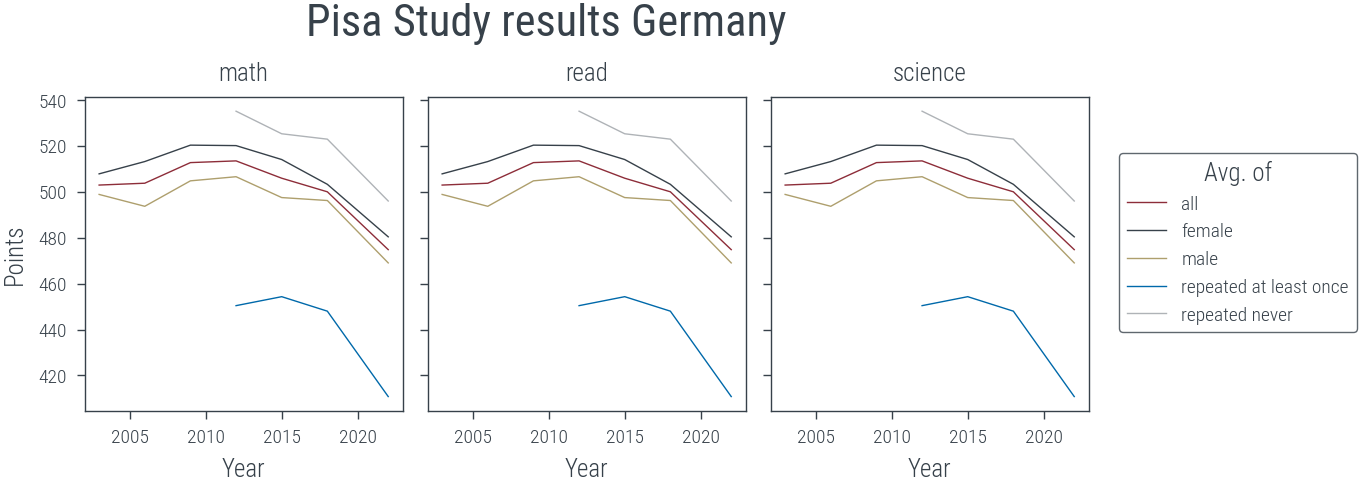

In [71]:
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

plot_data = all_subjects_clean.loc[all_subjects_clean["Jurisdiction"] == "Germany"].copy()


# Create three subplots with the different types for each subject
for idx, subject in enumerate(plot_data["Subject"].unique()):
    ax = axs[idx]
    subject_data = plot_data.loc[all_subjects_clean["Measure"] == "avg"].loc[all_subjects_clean ["Subject"] == "math"].copy()
    
    # Create the lines in teh axs
    for t in subject_data["Type"].unique():
        type_data = subject_data.loc[all_subjects_clean["Type"] == t].copy()
        ax.plot(
            type_data["Year"],
            type_data["Value"],
            label=t,
            lw=0.5   
        )
    ax.set_title(f"{subject}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Points") if idx == 0 else None

# Create shared legend
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0., title="Avg. of")

# Other settings
fig.suptitle("Pisa Study results Germany", fontsize=16)

plt.show()